## Issue Resolution Time as an Indicator for Complexity

We will use the Mann Whitney Ranksum U Test as our test of choice as we can not easily assume normality in our data.

In [1]:
import yaml
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import datetime
import re
from scipy.stats import mannwhitneyu

plt.style.use('seaborn-deep')

noteb_dir = Path().resolve()
plot_dir = noteb_dir / "plots"
plot_dir.mkdir(exist_ok=True)

We will load the data from two csv files containing:

 - Issues with the label "good first issues" (df_gfi.csv)
 - Issues without said label. (df_ngfi.csv)

In [2]:

regex = re.compile(r'((?P<days>\d+)\sdays)\s(?P<hours>\d+):(?P<minutes>\d+):(?P<seconds>\d+).')
def parse_time(time_str):
    parts = regex.match(time_str)
    if not parts:
        return
    parts = parts.groupdict()
    time_params = {}
    for (name, param) in parts.items():
        if param:
            time_params[name] = int(param)
    return datetime.timedelta(**time_params).total_seconds()

In [3]:

# Load the non_good_first_issue data
df_ngfi = pd.read_csv(noteb_dir / "df_ngfi_1000.csv")
df_ngfi.loc[:, 'res_time'] = df_ngfi["res_time"].apply(parse_time)

# Load the good_first_issue data
df_gfi = pd.read_csv(noteb_dir / "df_gfi_1000.csv")
df_gfi.loc[:, 'res_time'] = df_gfi["res_time"].apply(parse_time)

After loading the data we could just apply the Mann-Whitney U Test as it does not need any prior assumptions about our data.
But let us explore the data a bit first.

First lets have a look at the distirbution of resolution times:

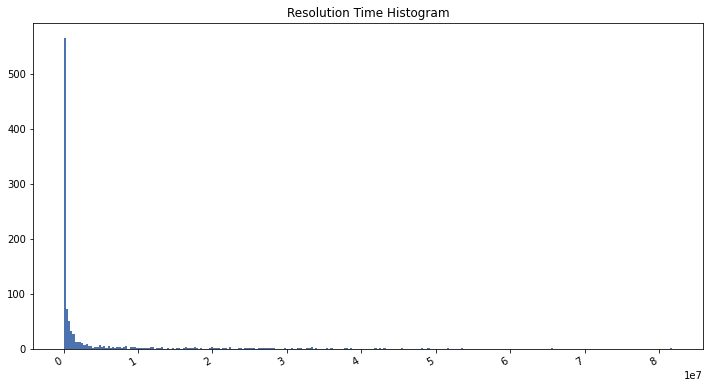

In [4]:
# Show Histograms of the NGFI-Data
plt.figure(figsize=(12,6))
plt.hist(df_ngfi["res_time"], bins="auto")
plt.title("Resolution Time Histogram")
ax = plt.gca()
plt.setp(ax.get_xticklabels(), rotation=30, ha="right")
plt.savefig(plot_dir / "fig_hist_rest_ngfi.png")
plt.show()

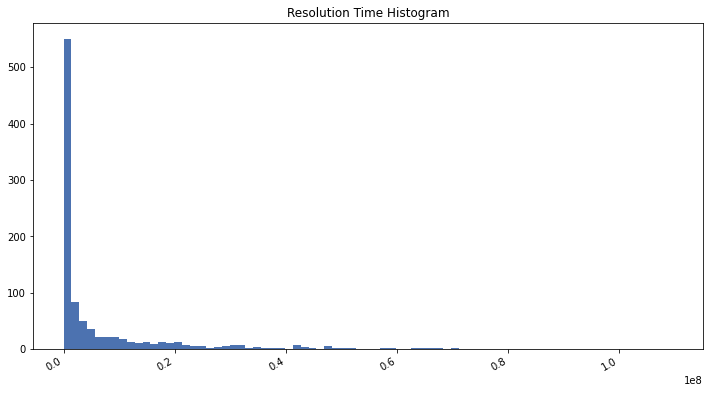

In [5]:
# Show Histograms of the GFI-Data
plt.figure(figsize=(12,6))
plt.hist(df_gfi["res_time"], bins="auto")
plt.title("Resolution Time Histogram")
ax = plt.gca()
plt.setp(ax.get_xticklabels(), rotation=30, ha="right")
plt.savefig(plot_dir / "fig_hist_rest_gfi.png")
plt.show()

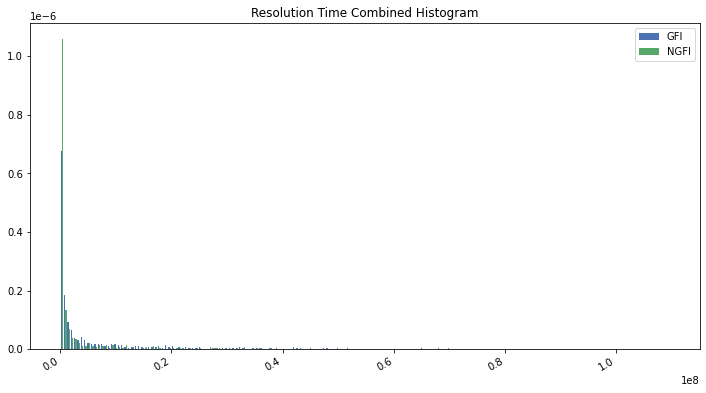

In [6]:
# Show a combined histogram
plt.figure(figsize=(12,6))
plt.hist([df_gfi["res_time"], df_ngfi["res_time"]], bins="auto", label=["GFI", "NGFI"], density=True)
plt.title("Resolution Time Combined Histogram")
ax = plt.gca()
plt.setp(ax.get_xticklabels(), rotation=30, ha="right")
plt.legend(loc='upper right')
plt.savefig(plot_dir / "fig_hist_rest_comb_gfi.png")
plt.show()

As we can see from both examples the data is by far not normally distributed.
Which makes sense if one considers that we cannot have negative resolution,
and that the resolution time is expected to get more sparse over time.

We can now apply the Mann-Whitney U Test on the data:

In [7]:
# two sided mann whitney test
statistic, p_value = mannwhitneyu(df_gfi["res_time"],df_ngfi["res_time"], alternative="two-sided")
print(statistic, p_value)

685108.0 1.3266214844741043e-46


We check if our good first issues are different in median resolution time from the non labeled data.
As the p-value is way below $\alpha=0.05$ we reject the $H_0$,
therefore we can assume that there exists a difference in medians.

We now check if the resolution time is greater or smaller by doing a one-sided Mann Whitney Test:

In [8]:
# one sided mann whitney test
statistic, p_value = mannwhitneyu(df_gfi["res_time"],df_ngfi["res_time"], alternative="greater")
print(statistic, p_value)

685108.0 6.633107422370522e-47


We can again see that the p-value is way below the $\alpha=0.05$ threshold.
Therefore we can assume that issues having the label good first issue, in general, take less time to be resolved.

This result may seem like a good singular predictor but we can not safely exclude
the fact that the existence of such a label can inform a users decision to work on that issue.

We should also have a look at the corresponding boxplot to get a better image of the difference:

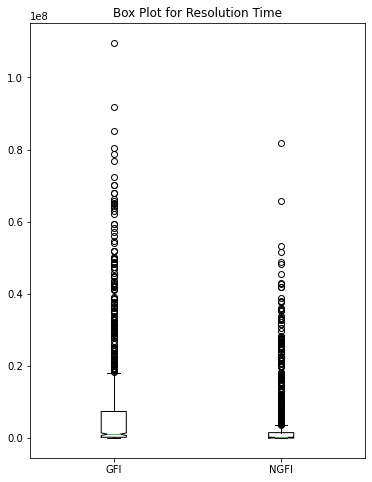

In [11]:
plt.figure(figsize=(6,8))
plt.title("Box Plot for Resolution Time")
plt.boxplot([df_gfi["res_time"], df_ngfi["res_time"]], notch=True, labels=["GFI", "NGFI"])
plt.savefig(plot_dir / "fig_box_rest.png")
plt.show()
